In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [22]:

url = 'https://raw.githubusercontent.com/SahilBansari/CODSOFT/main/Movie%20Rating/IMDb%20Movies%20India.csv'
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [23]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


In [24]:
# Drop rows where Rating is missing (target column)
df = df.dropna(subset=['Rating'])

# Clean duration (convert "110 min" to 110 as int)
df['Duration'] = df['Duration'].str.replace(' min', '').astype(float)

# Fill missing Duration with median
df['Duration'].fillna(df['Duration'].median(), inplace=True)

# Fill missing values in categorical columns with "Unknown"
for col in ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    df[col].fillna("Unknown", inplace=True)

# Show updated missing values
print("\nMissing Values After Preprocessing:")
print(df.isnull().sum())


Missing Values After Preprocessing:
Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64


In [25]:
# For simplicity, encode only the top 10 most frequent values for Director and Actors
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    top_10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].apply(lambda x: x if x in top_10 else 'Other')

# One-hot encode Genre, Director, and Actors
df_encoded = pd.get_dummies(df, columns=['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], drop_first=True)

# Preview encoded dataframe
print("\nEncoded DataFrame Columns:")
print(df_encoded.columns)


Encoded DataFrame Columns:
Index(['Name', 'Year', 'Duration', 'Rating', 'Votes',
       'Genre_Action, Adventure', 'Genre_Action, Adventure, Biography',
       'Genre_Action, Adventure, Comedy', 'Genre_Action, Adventure, Crime',
       'Genre_Action, Adventure, Drama',
       ...
       'Actor 3_Anupam Kher', 'Actor 3_Mithun Chakraborty', 'Actor 3_Other',
       'Actor 3_Paresh Rawal', 'Actor 3_Pran', 'Actor 3_Prem Chopra',
       'Actor 3_Raj Babbar', 'Actor 3_Shakti Kapoor',
       'Actor 3_Shatrughan Sinha', 'Actor 3_Unknown'],
      dtype='object', length=477)


In [35]:
# Drop non-informative and target columns
X = df_encoded.drop(columns=['Rating', 'Name', 'Year', 'Votes'])  # Remove extra non-predictive or unused columns
y = df_encoded['Rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop any non-numeric columns before scaling
non_numeric_cols = X_train.select_dtypes(include='object').columns.tolist()
if non_numeric_cols:
    print(f"Dropping non-numeric columns: {non_numeric_cols}")
    X_train = X_train.drop(columns=non_numeric_cols)
    X_test = X_test.drop(columns=non_numeric_cols)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🔍 Linear Regression Evaluation
MAE: 1.041
RMSE: 1.308
R² Score: 0.080

🔍 Random Forest Evaluation
MAE: 1.122
RMSE: 1.435
R² Score: -0.108

🔍 XGBoost Evaluation
MAE: 1.026
RMSE: 1.290
R² Score: 0.105

Model Comparison Table:
               Model       MAE      RMSE        R2
0  Linear Regression  1.040808  1.308050  0.079687
1      Random Forest  1.121562  1.435083 -0.107747
2            XGBoost  1.025761  1.289634  0.105419


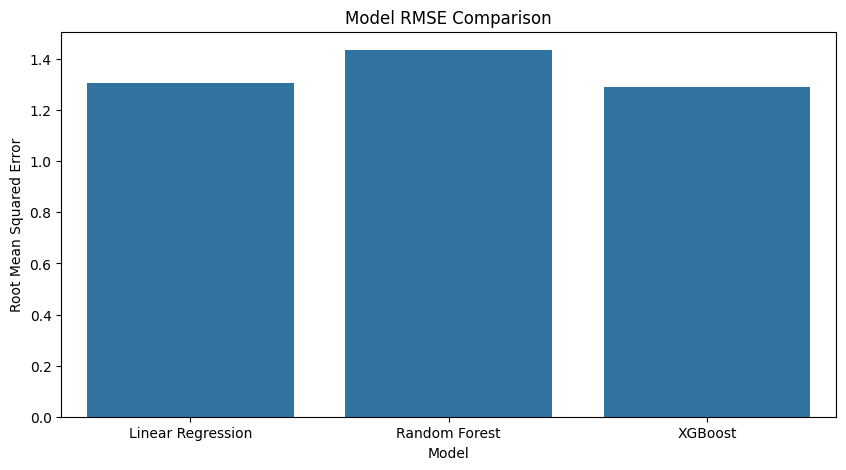

In [36]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # No need to scale for tree models

# XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# ✅ Cell 7: Model Evaluation
def evaluate_model(name, model, X_test_input, y_test):
    preds = model.predict(X_test_input)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\n🔍 {name} Evaluation")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
results.append(evaluate_model("Linear Regression", lr, X_test_scaled, y_test))
results.append(evaluate_model("Random Forest", rf, X_test, y_test))
results.append(evaluate_model("XGBoost", xgb, X_test, y_test))

# Results as DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(results_df)

# Visualize
plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title("Model RMSE Comparison")
plt.ylabel("Root Mean Squared Error")
plt.show()



In [40]:
def predict_user_rating():
    print("\n🔮 Enter movie details for rating prediction")

    genre = input("Genre (e.g. Comedy, Drama, Action): ").strip()
    duration = float(input("Duration (in minutes): "))
    director = input("Director Name: ").strip()
    actor = input("Lead Actor Name: ").strip()

    # Adjust to training categories
    director = director if director in df['Director'].value_counts().nlargest(10).index else 'Other'
    actor = actor if actor in df['Actor 1'].value_counts().nlargest(10).index else 'Other'

    # Prepare dictionary
    input_dict = {col: 0 for col in X.columns}
    if 'Duration' in input_dict:
        input_dict['Duration'] = duration

    # Set one-hot fields
    for col in X.columns:
        if f"Genre_{genre}" == col:
            input_dict[col] = 1
        if f"Director_{director}" == col:
            input_dict[col] = 1
        if f"Actor 1_{actor}" == col:
            input_dict[col] = 1

    # Create DataFrame
    user_df = pd.DataFrame([input_dict])
    user_df = user_df[X.columns]
    user_df_scaled = scaler.transform(user_df)

    # Predict
    prediction = xgb.predict(user_df_scaled)[0]
    print(f"\n⭐ Predicted Movie Rating: {prediction:.2f} / 10")

# Run prediction
predict_user_rating()




🔮 Enter movie details for rating prediction
Genre (e.g. Comedy, Drama, Action): Action
Duration (in minutes): 124
Director Name: Rohit Shetty
Lead Actor Name: Ajay Devgn

⭐ Predicted Movie Rating: 5.57 / 10
